[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Chuvard/ARIMA/blob/main/ARIMA.ipynb)

## Outline

1. Theoretical background for the ARIMA model
2. Problem Statement
3. Model construction
    * 3.1. Importing packages and data set
    * 3.2. How to choose ARIMA model parameters
    * 3.3. Fit an ARIMA model
    * 3.4. Interpretation of ARIMA Model Results
    * 3.5. How to Get AIC for the ARIMA model in Python
    * 3.6. Plot ARIMA Model
    * 3.7. Evaluate ARIMA Model

## 1. Theoretical background for the ARIMA model

### AR (autoregression) and MA (moving average) intuition in ARIMA model

* Autoregression part (AR) from ARIMA model measures the dependency of a particular data samples with a few past observations. The difference between two adjustment data points are measured and integrated in order to make data patterns stationary (tidying trend, seasonality, rising variance out) or minimize the obvious correlation with past data.

* Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).

* Moving Average (MA) from ARIMA model helps to compress and bring out significant features from the data. 

### ARIMA model parameters ARIMA (p, d, q)

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

#### AR(p) denotes autoregression model of the order 'p' 
in linear form with Epsilon as the 'white noise'

$$ Y_t = \alpha + \beta_1 * Y_{t-1} + \beta_2* Y_{t-2} + ... + \beta_p * Y_{t-p} + \epsilon_1 $$

#### MA(q) denotes a Moving Average of the order 'q' 

Next, the moving average MA(q) is defined as follows:
$$ y_t = c + \epsilon_t + \theta_1 * \epsilon_{t-1} + \theta_2 * \epsilon_{t-2} + ... + \theta_q * \epsilon_{t-q} $$

#### Data time shifting (d) parameter

In order to calculate the difference of two adjustment data points we have to so:
$$ y_t^{'} = y_t - y_{t-1} $$
implying **B** Backshift operator to shift yields:
$$ y_t^{'} = y_t - y_{t-1} = y_t - B * y_t = (1 - B) * y_t $$

or using 'd' parameter if we need handle to d-last periods of time
$$ (1 - B)^d * y_t **

### Final version of ARIMA model

$$ y_t^{'} = c + \phi_1 * y_{t-1}^{'} + ...+ \phi_p * y_{t-p}^{'} + \theta_1 * \epsilon_{t-1} + ... + \theta_1 * \epsilon_{t-q} + \epsilon_t $$

## 2. Problem statement 

Forecasting the number of users connected to the server in that minute, using the ARIMA model

## 3. Model construction

### 3.1. Importing packages and data set

In [1]:
### Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Chuvard/ARIMA/main/wwwusage.csv', names=['', 'minute', 'value'], header=0)
print(f"Total samples: {len(df)}")
df.reset_index()
print(df.head())

# df_1 = pd.read_csv('wwwusage.csv', names=['value'], header=0)
# print(f"Total samples: {len(df_1)}")
# print(df_1.head())

Total samples: 100
      minute  value
0  1       1     88
1  2       2     84
2  3       3     85
3  4       4     85
4  5       5     84


In [3]:
## Optional
print(df.value[:20])
print(df.columns)

0      88
1      84
2      85
3      85
4      84
5      85
6      83
7      85
8      88
9      89
10     91
11     99
12    104
13    112
14    126
15    138
16    146
17    151
18    150
19    148
Name: value, dtype: int64
Index(['', 'minute', 'value'], dtype='object')


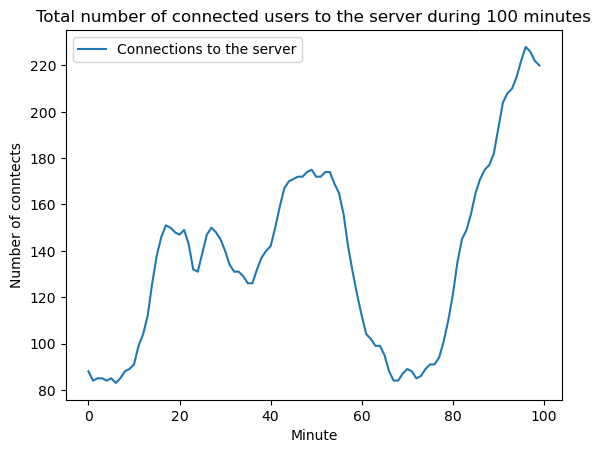

In [4]:
## Plot the graph of connected users to the server
## plot graph
sns.lineplot(df.value, label='Connections to the server')
plt.legend()

plt.title('Total number of connected users to the server during 100 minutes')
plt.xlabel('Minute')
plt.ylabel('Number of conntects')
plt.show()

#### 3.2. How to choose ARIMA model parameters
We will look at the Autocorrelation function (ACF) plots and the Partial Autocorrelation function (ACF) plots to identify the overall correlation in the data.
Moreover, further we compute the moving average and standard diviation or using existing test from a Augmented Dickey Fuller (ADF) test to determine the properties of the time series.
But we should set three fundamental parameters of the ARIMA model (p, d, q) firstly.

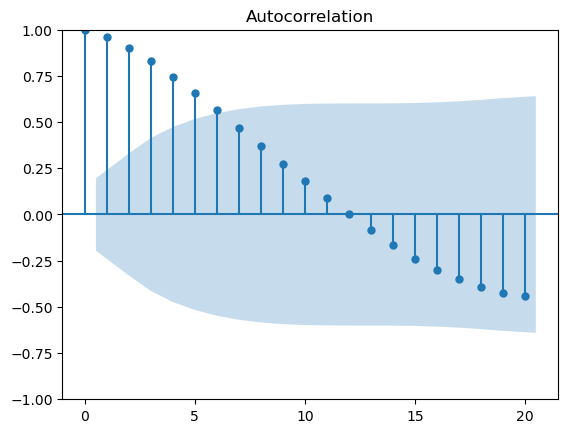

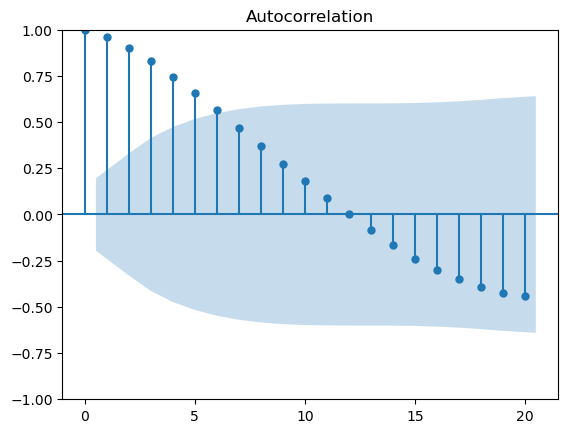

In [5]:
## Plot the autocorrelation graph
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value)

Summary: it is obvious that data is not ideal for the ARIMA model to start autoregressive training momentally. 

#### 1st Order differencing (d=1)

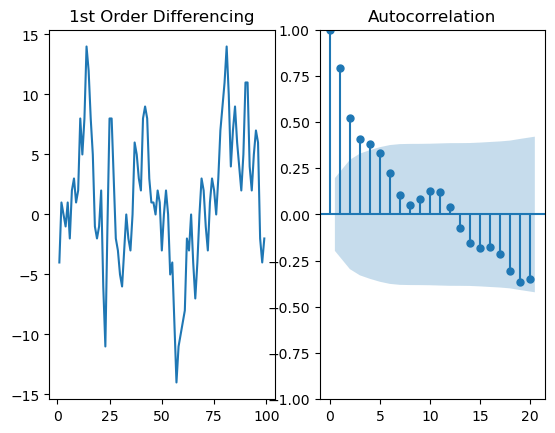

In [6]:
## Let's see how differencing 'd = 1' parameter makes the data stationary
## First subplot shows the 1st order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff())

## Second subplot displays the autocorrelation function of the differenced series 
ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show()

Summary: as shown above, 1st order differencing shakes up autocorrelation considerably (did not clear the data from seasonality, trend)

#### 2nd Order differencing (d=2)

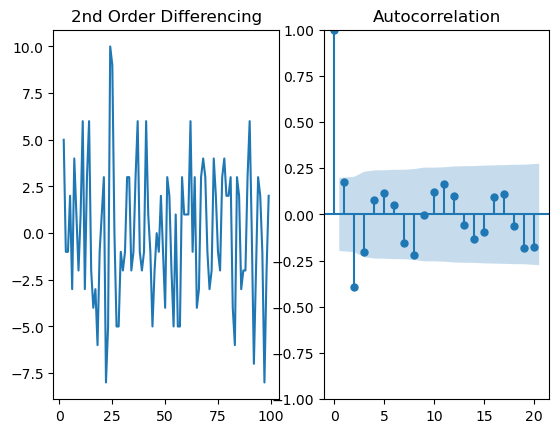

In [7]:
## Let's see how differencing 'd = 2' parameter makes the data stationary
## First subplot shows the 2nd order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff())

## Second subplot displays the autocorrelation function of the differenced series 
ax2 = f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna(), ax=ax2)
plt.show()

Summary: If existing positive values as autocorrelation as well as the data point of each lag (in the horizontal axis) then we need to increase the differencing gradually. On the opposite, the more data points of each lag (in the horizontal axis) having negative values it leads to over-differenced.

#### Finding the differencing parameter (d) due to the Augmented Dickey-Fuller test (ADF). 
The main idea of this test is if the p-value decline bellow the significance level of 0.05, then the data is stationary (we choose that value of differencing). Otherwise, we have to increment the differencing parameter (d) by one.

In [8]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())
print('p-value: ', result[1])

result = adfuller(df.value.diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.value.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.12441935447109487
p-value:  0.07026846015272707
p-value:  2.8434287555470966e-17


Summary: As wee can see above, after the 2nd order differencing, the p-value drops below the acceptable threshold (0.05), so we can consider that the order of differencing (d) as 2. However, the p-value for the 1st order is much closer to the lastly mentioned threshold (0.05) so the optimal value the order of differencing (d) equal to 1. 

#### Finding the parameter (p) of the order for the autoregressive model AR(p)

Mathematically in the equation below, the partial autocorrelation of series and a lag would be that lag's coefficient (alpha)

$$ Y_t = \alpha_0 + \alpha_1 * Y_{t-1} + \alpha_2* Y_{t-2} + ... + \alpha_p * Y_{t-p}$$


Therefore, we determine (p) parameter based on the most significant lag in the partial autocorrelation plot. 

We can check the plot up to 2nd order difference to be sure.

<function matplotlib.pyplot.show(close=None, block=None)>

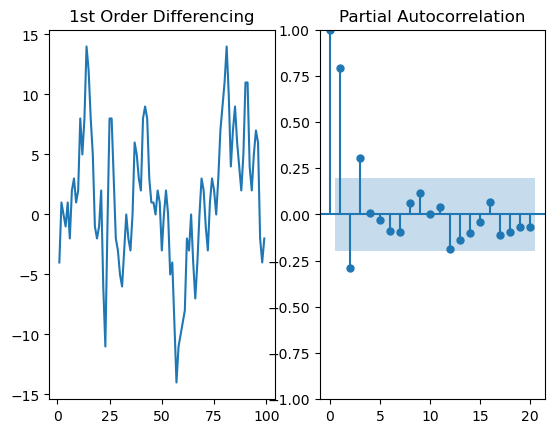

In [9]:
## Import partial autocorrelation function from statistic modelling package
from statsmodels.graphics.tsaplots import plot_pacf

## First subplot shows the 1st order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff())

## Second subplot displays the partial autocorrelation function of the differenced series with the order of degree 1
ax2 = f.add_subplot(122)
plot_pacf(df.value.diff().dropna(), ax=ax2)
plt.show

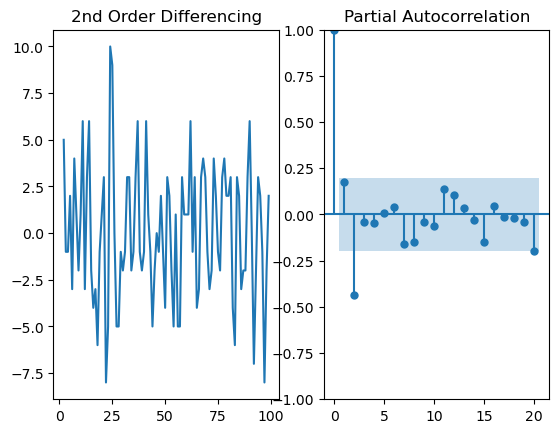

In [10]:
## First subplot shows the 2nd order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff())

## Second subplot displays the particial autocorrelation function of the differenced series with the order of degree 2 
ax2 = f.add_subplot(122)
plot_pacf(df.value.diff().diff().dropna(), ax=ax2)
plt.show()

Summary: From the graphs above we can see that the 1st lag is the most significant (in both graphs, it is the most significant among all lags). Thus, we consider the (p) parameter should be equal to 1.

#### Finding the parameter (q) of the order for the moving average MA(q)

The moving average MA(q) is defined as follows:
$$ y_t = c + \epsilon_t + \theta_1 * \epsilon_{t-1} + \theta_2 * \epsilon_{t-2} + ... + \theta_q * \epsilon_{t-q} $$

Therefore, we determine (q) parameter based on the most significant lag in the autocorrelation plot. 

Looking at the number of lags crossing thethreshold, we can determine how much of the past would be significant enough to consider for the future.

We can check the plot up to 2nd order difference to be sure.

<function matplotlib.pyplot.show(close=None, block=None)>

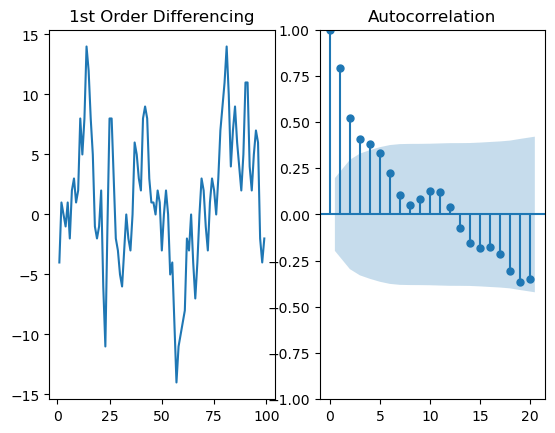

In [11]:
## Import partial autocorrelation function from statistic modelling package
from statsmodels.graphics.tsaplots import plot_acf

## First subplot shows the 1st order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff())

## Second subplot displays the autocorrelation function of the differenced series with the order of degree 1
ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show

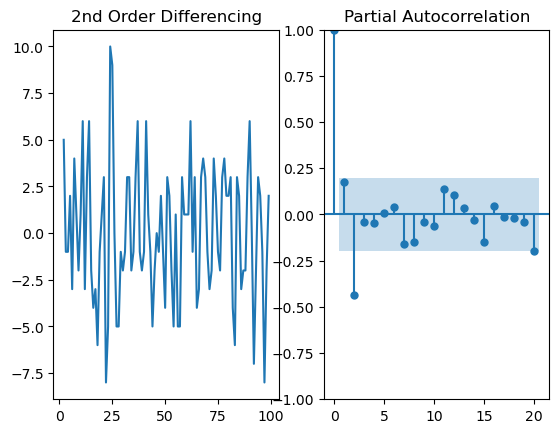

In [12]:
## First subplot shows the 2nd order differencing of the time series data
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff())

## Second subplot displays the autocorrelation function of the differenced series with the order of degree 2 
ax2 = f.add_subplot(122)
plot_pacf(df.value.diff().diff().dropna(), ax=ax2)
plt.show()

Summary: From the graphs above we can see that the 2nd lag is the most significant (in both graphs, it is the most significant among all lags). Therefore, we consider the moving average (MA) parameter (q) should be set to 2.

Thus, our final ARIMA model can be defined as ARIMA with the following parameters (p=1, d=1, q= 2).

### 3.3. Fit an ARIMA model

To construct the ARIMA model we have to use the SARIMAX class from the statsmodels.tsa.statespace.sarimax module, we can feed the data and the hyperparameters p, d, and q to it (in that order). Calling this module’s fit() method returns a trained model used for evaluation and inference.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value, order=(1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -254.126
Date:                Thu, 18 Jan 2024   AIC                            516.253
Time:                        15:03:54   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

### 3.4. Interpretation of ARIMA Model Results

Summary: 

As shown above, the model summary provides several statistical measures to evaluate the performance of our model. Furthermore, we also know the values of parameters for the ARIMA model (d, p, and q). 
As was mentioned before, the value of the moving average (MA) parameter or (q) equal to 2, and the value of the autoregression model (AR) parameter or (p) as 1.

Moreover, we can see other satistics from ARIMA model statistics such as Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-QuinnInformation Criterion (HQIC).

### 3.5. How to Get AIC for the ARIMA model in Python?

The Akaike Information Critera (or AIC) is a good measure for testing the goodness of how fit the model is mathematically. Information Criteria scores measure the amount of information lost by training and generalizing the ARIMA model. The AIC statiscics should be as low as possibleю

To reduce AIC, we can try changing the p, q, and d values or using training techniques like k-cross-validation.

#### Increasing the (d) parameter by 1 unit

In [14]:
## Change the (d) parameter from 1 to 2
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value, order=(1,2,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -252.595
Date:                Thu, 18 Jan 2024   AIC                            513.189
Time:                        15:03:54   BIC                            523.529
Sample:                             0   HQIC                           517.372
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6531      0.103      6.360      0.000       0.452       0.854
ma.L1         -0.4738      0.941     -0.503      0.615      -2.319       1.371
ma.L2         -0.5247      0.477     -1.100      0.2

Summary: Changing the value of “d” to 2 instead of 1 reduces the AIC from 516 to around 513. Unfortunately we can not directly compare the AIC statistic by changing of (d) parameter or the parameter of the degree of differencing. Changing the (d) parameter effectively shifts the data distribution and, thus, the likelihood computation. From the parameter mentioned in the above selection method we can see that setting (d) parameter to 2 it would be better choice overall.

#### Increasing the (q) parameter by 1 unit

In [15]:
## Change the (q) parameter from 2 to 3
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value, order=(1,1,3))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -252.289
Date:                Thu, 18 Jan 2024   AIC                            514.577
Time:                        15:03:54   BIC                            527.553
Sample:                             0   HQIC                           519.827
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8580      0.129      6.651      0.000       0.605       1.111
ma.L1          0.3429      0.174      1.971      0.049       0.002       0.684
ma.L2         -0.2852      0.197     -1.447      0.1

Summary: Changing the Moving Average's order by 1 unit (assigns it to 3) leads to a decrease in the AIC value from 516 to around 514.

### 3.6. Plot ARIMA Model

In [16]:
## Before making a graph to compare Actual and Predicted values of the server visits we have to split values of the ARIMA model to "Actual" and "Predicted" values by creating a new variable prediction that refers to "Predicted" values 
predictions = model.predict()

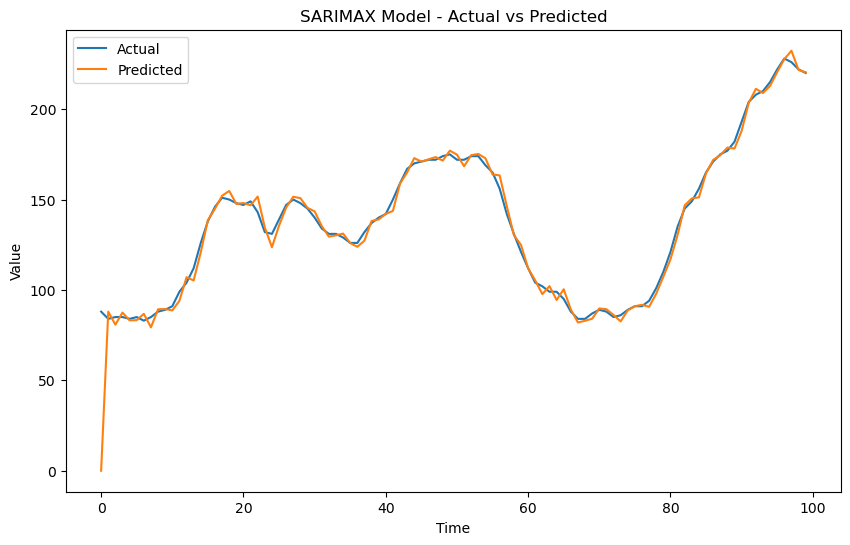

In [17]:
## Plot the "Actual" and "Predicted" values on the graph

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.value, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('SARIMAX Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Summary: 

The above graph indicates that "Predicted" values generated by the model are not leg distant from the original "Actual" values which suggests that our model has relatively good accuracy.

### 3.7. Evaluate ARIMA Model

Beyond visual analysis, we can use various error measures and metrics to evaluate the performance of our ARIMA model.

However, before evaluating the ARIMA model we need some test samples to compare our predicted samples.  Therefore, we can split our time-series data into train and test samples and infer the test set

Let us consider the first 80 of 100 samples for fitting the model.

In [18]:
## Limit our test set to 80 samples
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value[:80], order=(1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   80
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -203.020
Date:                Thu, 18 Jan 2024   AIC                            414.041
Time:                        15:03:54   BIC                            423.518
Sample:                             0   HQIC                           417.838
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5732      0.186      3.078      0.002       0.208       0.938
ma.L1          0.5533      0.207      2.668      0.008       0.147       0.960
ma.L2          0.0617      0.189      0.326      0.7

Summary: 
Comparing the test set of 80 examples to 100 examples the model has a tough task of predicting the exponential rise in its test set.

From the values seen in the model summary above, we can observe that the model does not perform as well with 80 samples as 100. 

#### To fix this kind of problem we try to change the hyperparamters of the ARIMA model (eg. changing 'd' to 2 degree of diferencing gives us the best prediction results among all combination of 'd' parameter) 

In [19]:
## Set the 'd' parameter to 2
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value[:80], order=(1,2,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   80
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -201.756
Date:                Thu, 18 Jan 2024   AIC                            411.512
Time:                        15:03:55   BIC                            420.938
Sample:                             0   HQIC                           415.285
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6478      0.113      5.720      0.000       0.426       0.870
ma.L1         -0.5207      4.108     -0.127      0.899      -8.571       7.530
ma.L2         -0.4789      1.942     -0.247      0.8

Summary: We can see that the key statistics with setting parameter of 'd' to 2 causes to decline in key statistics of model evaluation (AIC and BIC statistics)

#### Plot the forecast that the model fits for the 80 samples

In [20]:
## Before making a graph to compare Actual and Predicted values of the server visits we have to split values of the ARIMA model to "Actual" and "Predicted" values by creating a new variable prediction that refers to "Predicted" values 
predictions = model.predict()

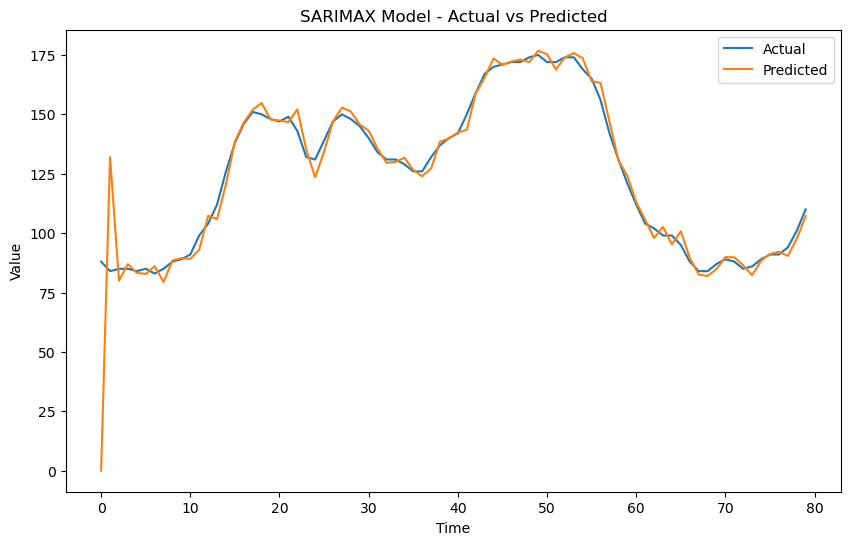

In [21]:
## Plot the "Actual" and "Predicted" values on the graph

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.value[:80], label='Actual')
plt.plot(predictions[:80], label='Predicted')
plt.legend()
plt.title('SARIMAX Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Summary: As expected from the model summary, the forecast fits more loosely than the original model. Nevertheless, for testing, we move ahead with inference.

#### Predict values of users connected to the server for upcoming 20 minutes 

Use the model's method called 'forecast' to compute n-predicted samples given the value of n.

Since our test set is the size of 20, we have to predict 20 instances that occur right after the last timestamp of the training set.

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(df.value[:20], order=(1,2,2))
model_pred = arima_model.fit()
print(model_pred.summary())

predictions_20 = model_pred.predict()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   20
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 -47.554
Date:                Thu, 18 Jan 2024   AIC                            103.108
Time:                        15:03:55   BIC                            106.669
Sample:                             0   HQIC                           103.599
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3821      1.150     -0.332      0.740      -2.637       1.872
ma.L1          0.4745      1.154      0.411      0.681      -1.787       2.736
ma.L2         -0.1372      0.429     -0.320      0.7

In [23]:
## Compare the last 20 predicted and actual values of users' connections for server
y_pred = pd.Series(model_pred.predict())
y_true = df.value[80:]

print(np.array(y_pred).astype(np.uint8))
print(np.array(y_true))

print("number of predictions: ", len(y_pred))
print("number of actuals: ", len(y_true))

[  0 132  79  86  84  83  85  80  87  90  90  93 107 107 121 139 149 154
 156 148]
[121 135 145 149 156 165 171 175 177 182 193 204 208 210 215 222 228 226
 222 220]
number of predictions:  20
number of actuals:  20


Summary: The model generates an error in a prediction (the predicted value rises with a higher degree rather than the actual value) that was caused by decreasing the test sample from 100 to 80 examples.

#### Additional metrics to evaluate the ARIMA model

For future use on a large number of predictions, we can not evaluate the samples manually. 

We can use for this purpose the metrics from the Key Performance Indicators (KPI).

We can calculate some of the most insignful performance error metrics such as the Root Mean Square Error (RMSE), Mean Absolute Error (MAE), Mean Percentage Error (MPE), Mean Absolute Percentage Error (MAPE), correlation coefficient (to measure similarity), and Min-Max error.

In [24]:
## Compare the last 20 predicted and actual values of users' connections for server
y_pred = pd.Series(model_pred.predict())
y_true = df.value[80:]

## Transfer Predicted and Actual values into array format
y_print = np.asarray(y_pred)
y_true = np.array(y_true)

## Calculate the MAPE, MAE, MPE, RMSE, and correlation coefficient
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))                      # Mean Absolute Percentage Error
mae = np.mean(np.abs(y_pred - y_true))                                      # Mean Absolute Error
mpe = np.mean((y_pred - y_true)/y_true)                                     # Mean Percentage Error
rmse = np.mean((y_pred - y_true)**2)**0.5                                   # Root Mean Square Error
corr = np.corrcoef(y_pred, y_true)[0,1]                                     # Corrrelation Coefficient

## Define the minimum as a well as the maximum values and calculate the minmax statistic
mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
minmax = 1 - np.mean(mins/maxs)                                             # minmax

## Print out the corr, mae, mape, minmax, mpe, rmse
import pprint
pprint.pprint({'mape': mape, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'mimax': minmax})

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

However, these metrics are more useful to measure errors in general regression models. For the time series models case, metrics like MAE or MAPE do not easily capture the scale of the values. 

MAE defines the absolute difference between predicted and actual values and averages from them over all samples in the test set. Over time, the change in the values is lost, and the context of actual values becomes more significant. As an example, an MAE metric with a value of 100 would be a good score if the test set has a size of 10,000 but it could be terrible for a test set with hundreds of examples.

The same logic has an RMSE metric.

On the other hand, a MAPE metric is scale-dependent and is reliable for such a changing time series as long as the value never reaches 0 else, the score will be undefined.

In this sense, the better alternative is the mean absolute scaled error (MASE) as per general consensus.

$$ MASE = \frac{MAE}{(1/n-1) * \sum_{i=2}^n*|a_i-a_{a-1}|} $$

MASE considers the data the model was trained on $a_i$ in the form of 1st-order changes or differences (d=1). This makes it a good measure for time-series data irrespective of scale or time. Let's implement it in Python as below:

In [ ]:
n = np.array(df[:80]).shape[0]
d = np.abs(np.diff(np.array(df[:80].value))).sum()/(n-1)

errors = np.abs(y_true - y_pred)
print(errors.mean()/d)

20.190060914800135


Summary: the Mean Absolute Scaled Error (or MASE) statistic has a value of 20.19 meaning that the error between predicted and actual values has 20.19 points on average.